In [1]:
import re
from collections import Counter
import os
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import copy

In [2]:
# lib_path = '/home/ksn38/frameworks/laravel-10.10/'
# lib_path = 'C:\\Python37\\Lib\\site-packages\\django\\'
# lib_path = 'E:\\Temp\\bitrix\\'
lib_path = 'C:\\Users\\ksn\\frameworks\\laravel-10.x\\'
# lib_path = 'C:\\Users\\ksn\\frameworks\\spring-boot-main\\'
# lib_path = 'D:\\Temp\\M\\libs\\laravel-10.x\\'

In [3]:
if os.name == "posix":
    lib = lib_path.split('/')[-2]
elif os.name == "nt":
    lib = lib_path.split('\\')[-2]

In [4]:
class Parser:
    def __init__(self):
        self.list_classes = []
        self.list_classes_for_graph = []
        self.list_classes_for_html = ['<!DOCTYPE html><html><head><meta charset="utf-8"><title></title>\
            <style>body{background-color: #13191e}div{color: #d2d2d2; font-family: Trebuchet MS; font-size: 15px}\
            a{color: #55e1e6; font-family: Trebuchet MS; font-size: 15px}span{color: #efefef}.red{color: #e0876a}\
            .orange{color: #f9ccac}</style></head><span><i>The numbers are amount of subclasses and size of file</i></span><br><br>']
        self.list_files_sizes = []
        self.dict_classes_sizes = dict()
        
    def open_and_reg(self, path):
        with open(path, 'r', encoding='utf-8') as file:
            try:
                file_readed = file.read()
                classes = re.findall('^class\s.*|^interface.*|^abstract.*|^trait.*', file_readed, re.MULTILINE)
            except UnicodeDecodeError:
                classes = []

            for i in classes:
                i = i.replace('\\', '.')
                #class is taken for graph and counter at least 3 characters in name 
                list_1_or_more_classes = re.findall('\w{3,}\.*', i)
                list_1_or_more_classes_origin = list_1_or_more_classes.copy()
                for k in list_1_or_more_classes_origin:
                    if k in {'class', 'extends', 'interface', 'abstract', 'implements', 'trait'} \
                    or k[-1] == '.':
                        list_1_or_more_classes.remove(k)
                self.list_classes.extend(list_1_or_more_classes)
                if len(list_1_or_more_classes) > 0:
                    self.dict_classes_sizes[list_1_or_more_classes[0]] = os.path.getsize(path)
                if len(list_1_or_more_classes) > 1:
                    for j in list_1_or_more_classes[1:]:
                        if list_1_or_more_classes[0] != j:
                            self.list_classes_for_graph.append([list_1_or_more_classes[0], j])

            if len(classes) > 0:
                self.list_classes_for_html.append(f'<a href="{path}">{path}</a>&nbsp&nbsp&nbsp\
                <span style="color: rgb(50 ,50, blue)">{os.path.getsize(path)}</span>')
                self.list_files_sizes.append(os.path.getsize(path))

            if path[-2:] == 'va' or path[-2:] == 'ss':
                r_java = Replacer_for_html_java(classes)
                r_java.replace(self.list_classes_for_html, file_readed)
            else:
                r = Replacer_for_html(classes)
                r.replace(self.list_classes_for_html, file_readed)

    #run previous function on multiple files
    def printer(self, tuple_from_oswalk):
        files = tuple_from_oswalk[2]
        for f in files:
            if tuple_from_oswalk[0][-1] != '/' and f[-2:] in {'hp', 'js', 'ts', 'py', 'va', 'ss'}:
                self.open_and_reg(tuple_from_oswalk[0] + '/' + f)
            elif tuple_from_oswalk[0][-1] == '/' and f[-2:] in {'hp', 'js', 'ts', 'py', 'va', 'ss'}:
                self.open_and_reg(tuple_from_oswalk[0] + f)

In [5]:
class Replacer_for_html:
    def __init__(self, classes):
        self.classes = classes
    
    def replace(self, list_classes_for_html, file_readed):
        for c in self.classes:
            c_html = copy.deepcopy(c)
            c_html = c_html.replace('{', '')
            c_html = c_html.replace('}', '')
            c_html = c_html.replace('<', '&lt')
            c_html = c_html.replace('>', '&gt')
            list_classes_for_html.append(f'<div>{c_html}</div>')
            # methods and fields for html
            list_file = file_readed.split('\n')
            for i in range(len(list_file)):
                if list_file[i] == c:
                    try:
                        while list_file[i+1] == '' or list_file[i+1][0] == ' ' or list_file[i+1][0] == '{':
                            i += 1
                            if re.findall('^\s{1,}def\s.*|^\s{1,}public.*|^\s{1,}private.*|^\s{1,}protected.*|^\s{1,4}\w+\(.*', list_file[i]):
                                list_classes_for_html.append(f'<div>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;{list_file[i]}</div>')
                    except IndexError:
                        pass
        return list_classes_for_html

In [6]:
class Replacer_for_html_java:
    def __init__(self, classes):
        self.classes = classes
    
    def replace(self, list_classes_for_html, file_readed):
        for c in self.classes:
            c_html = copy.deepcopy(c)
            c_html = c_html.replace('{', '')
            c_html = c_html.replace('}', '')
            c_html = c_html.replace('<', '&lt')
            c_html = c_html.replace('>', '&gt')
            list_classes_for_html.append(f'<div>{c_html}</div>')
            # methods and fields for html
            list_file = file_readed.split('\n')
            for i in range(len(list_file)):
                if list_file[i] == c:
                    try:
                        while list_file[i+1] == '' or list_file[i+1][0] == '\t' or list_file[i+1][0] == '{':
                            i += 1
                            if re.findall('^\t{1,}public.*|^\t{1,}private.*|^\t{1,}protected.*', list_file[i]):
                                string = list_file[i]
                                string = string.replace('<', '&lt')
                                string = string.replace('>', '&gt')
                                list_classes_for_html.append(f'<div>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;{string}</div>')
                    except IndexError:
                        pass
        return list_classes_for_html

In [7]:
#run previous function on multiple directories
p = Parser()

for i in os.walk(lib_path):
    p.printer(i)

class_counter = Counter(p.list_classes)

In [8]:
class_counter_gt_1 = {}
class_counter_lt_gt = set()
min_subclasses = 2
max_subclasses = None

for i in class_counter.items():
    if i[1] > 1:
        class_counter_gt_1[i[0]] = i[1]
    if max_subclasses == None:
        if i[1] < min_subclasses + 1:
            class_counter_lt_gt.add(i[0])
    if max_subclasses != None:
        if max_subclasses + 1 < i[1] or i[1] < min_subclasses + 1:
            class_counter_lt_gt.add(i[0])          
    
class_counter_gt_1_origin = class_counter_gt_1.copy()

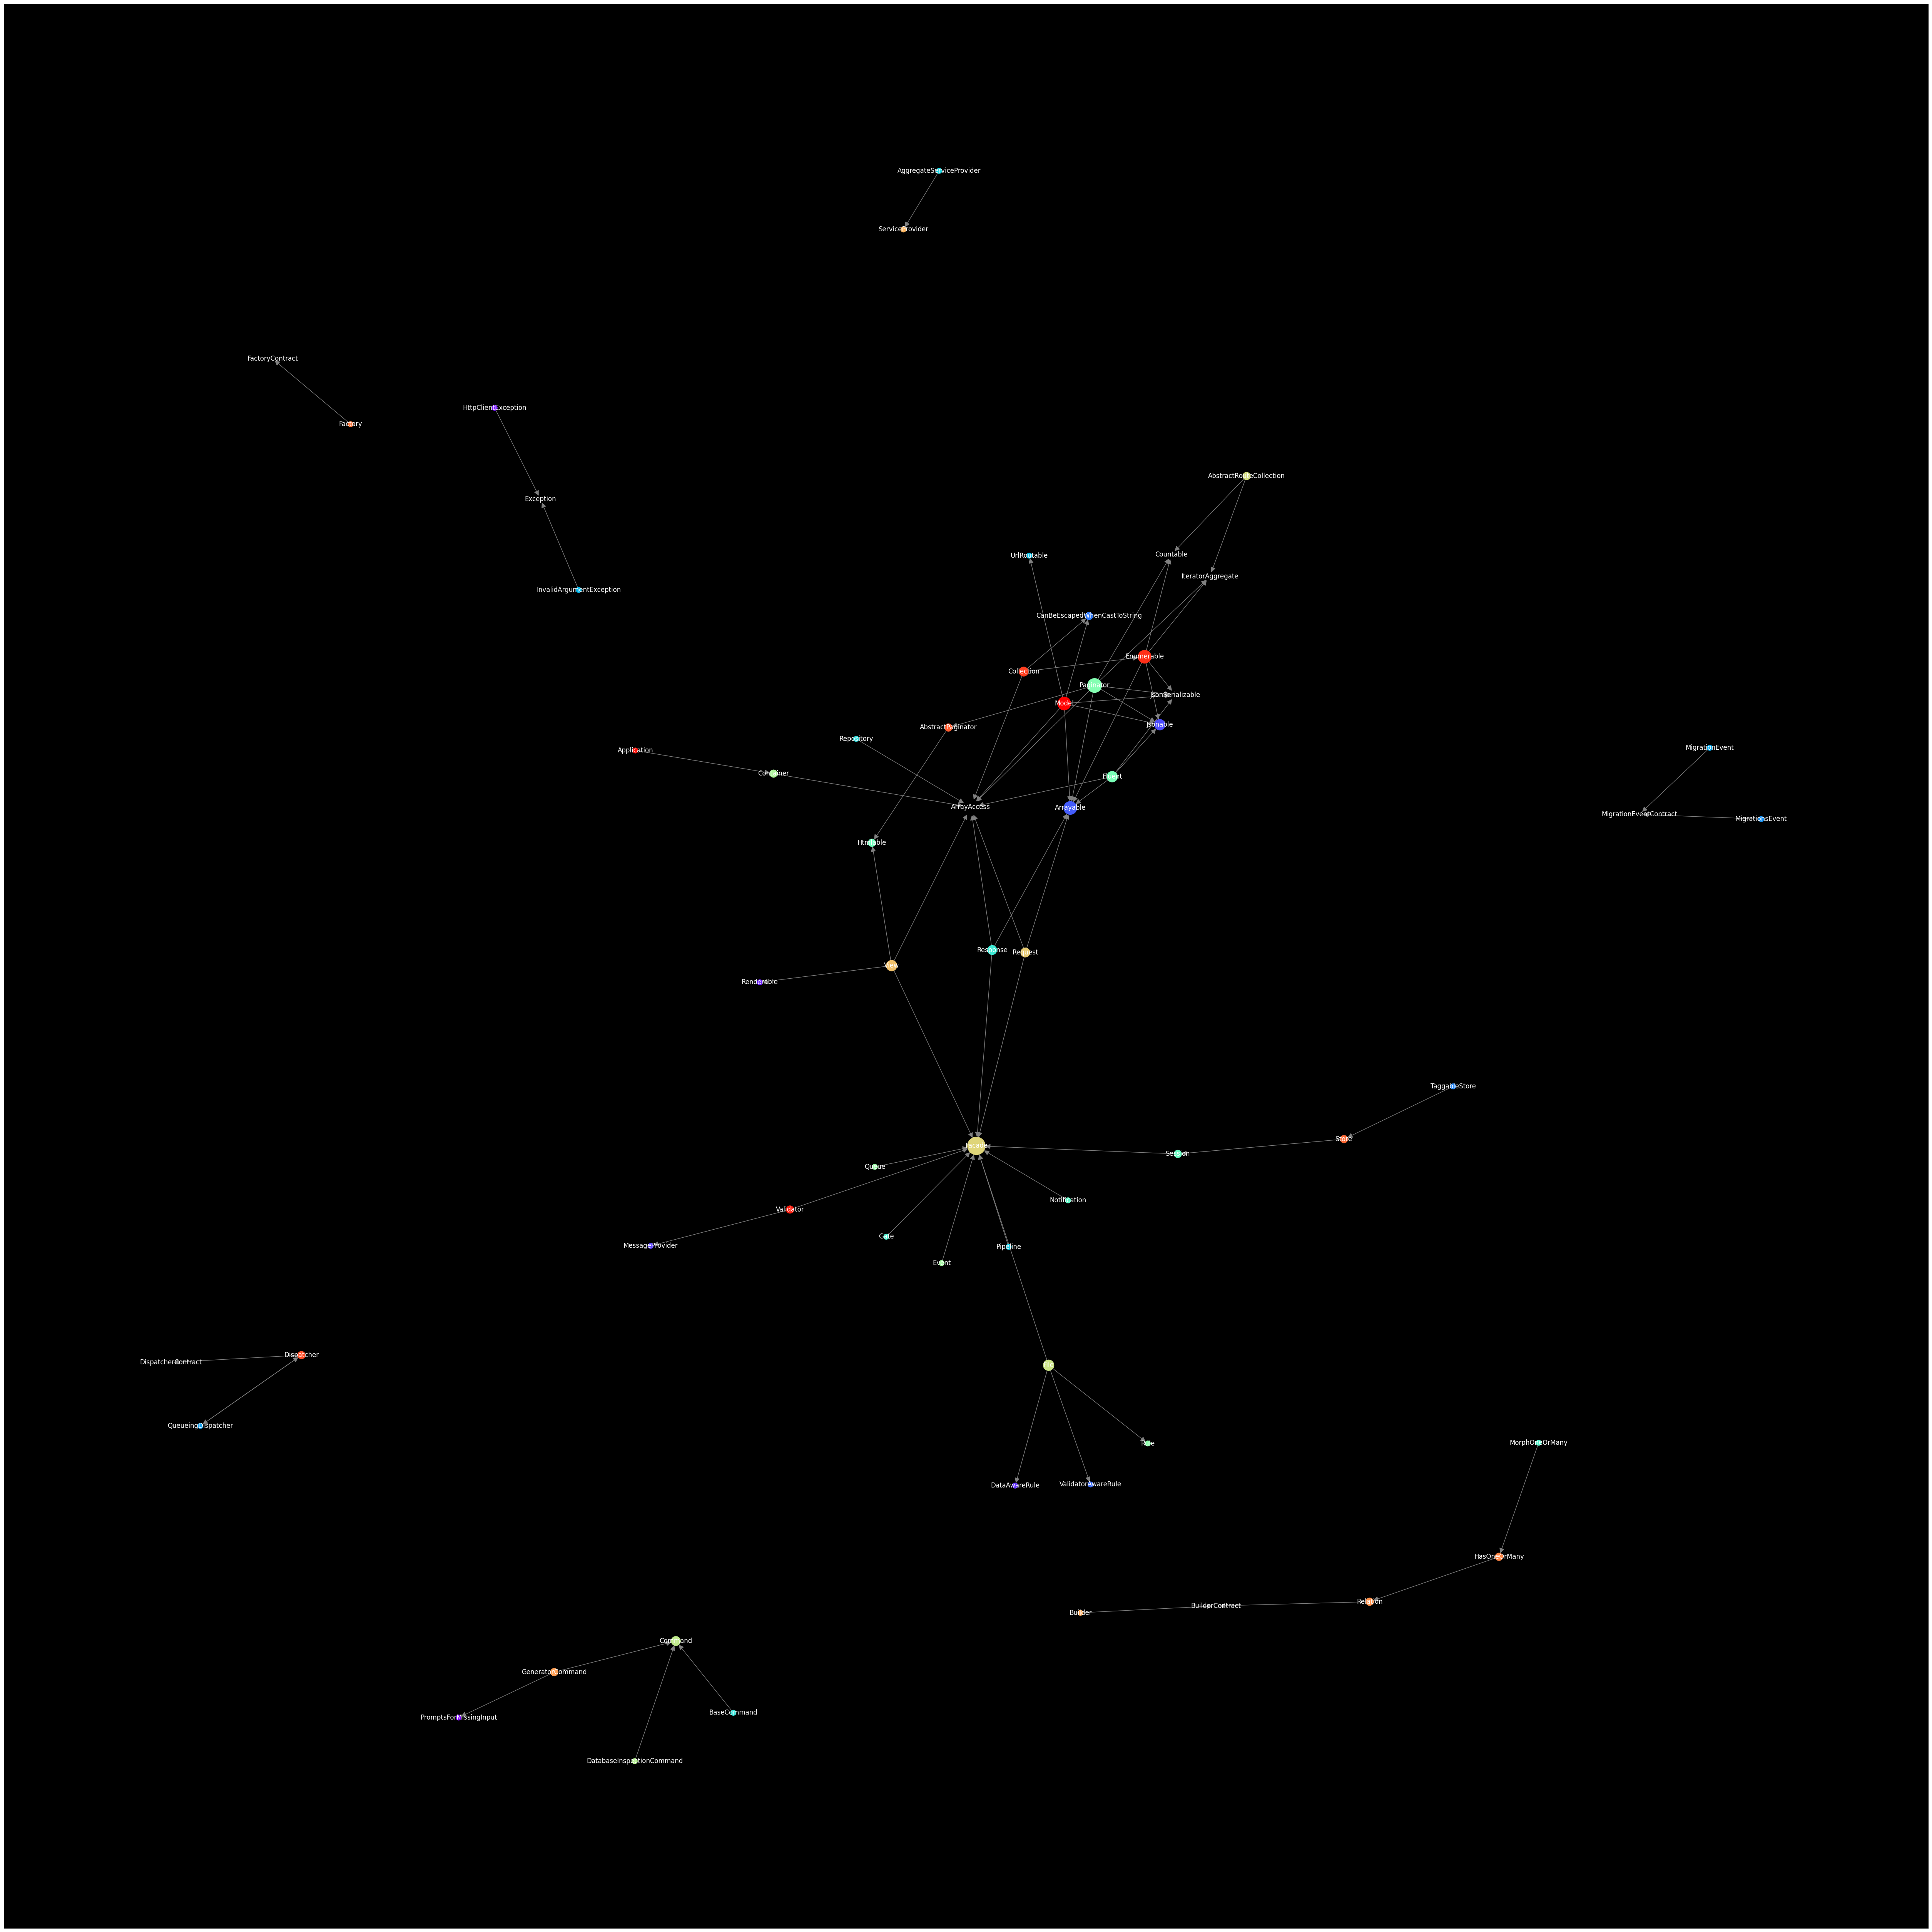

In [9]:
#create graph
size_image = 50

fig, ax = plt.subplots()
fig.set_size_inches(size_image, size_image)
fig.patch.set_visible(False)
ax.set_facecolor('k')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

DG = nx.DiGraph()
G = nx.Graph()

for i in p.list_classes_for_graph:
    if i[0] not in class_counter_lt_gt and i[1] not in class_counter_lt_gt:
        DG.add_edge(i[0], i[1])
        G.add_edge(i[0], i[1])

df = pd.DataFrame(list(G.degree), columns=['node','degree']).set_index('node')
df_size = pd.DataFrame({'node': list(p.dict_classes_sizes.keys()), 'size': list(p.dict_classes_sizes.values())})
df = pd.merge(df, df_size, how='left', on='node')
df['color'] = df['size'].rank()
vmin = df['color'].min()
vmax = df['color'].max()
cmap = plt.cm.rainbow

pos = nx.spring_layout(G, k=0.2, seed=38)
nx.draw_networkx(DG, pos=pos, arrows=True, arrowsize=20, node_size=df.degree*100, node_color=df['color'],\
                 edge_color='grey', font_color='white', cmap=cmap, vmin=vmin, vmax=vmax)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# sm.set_array([])
#cbar = plt.colorbar(sm)
# plt.savefig(f'{lib}_gt_{min_subclasses}_lt_{max_subclasses}.png')

In [10]:
#list of frequent classes in footer of html file
p.list_classes_for_html.append('<br><span><b>Classes counter:</b></span><br>')
for i in sorted(class_counter_gt_1_origin.items(), key= lambda item: item[1], reverse=True):
    p.list_classes_for_html.append(f'<a href="#{i[0]}">{i[0]}({i[1] - 1})</a>&nbsp&nbsp')

In [11]:
#values of class_counter_gt_1 have been changed for convenient colors
dict_line = dict(zip(sorted(set(class_counter_gt_1.values()), reverse=True), \
                     np.linspace(0, 255, len(set(class_counter_gt_1.values())))))

for k, v in class_counter_gt_1.items():
    class_counter_gt_1[k] = dict_line[v]

In [12]:
dict_colors_for_sizes = dict(zip(sorted(p.list_files_sizes),\
                                 np.linspace(0, 255, len(p.list_files_sizes))))

In [13]:
#added colors and counter values in html
for i in range(len(p.list_classes_for_html)):
    access_modifier = re.findall('private|protected|f\s__|f\s_', p.list_classes_for_html[i])
    if len(access_modifier) > 0:
        if access_modifier[0] == 'protected' or access_modifier[0] == 'f _':
            p.list_classes_for_html[i] = re.sub('<div>', '<div class="orange">', p.list_classes_for_html[i])
        if access_modifier[0] == 'private' or access_modifier[0] == 'f __':
            p.list_classes_for_html[i] = re.sub('<div>', '<div class="red">', p.list_classes_for_html[i])
            
    size_for_color = re.findall('ue\)">\d*', p.list_classes_for_html[i])
    if len(size_for_color) > 0:
        p.list_classes_for_html[i] = re.sub('blue', \
                     str(dict_colors_for_sizes[int(size_for_color[0][5:])]), p.list_classes_for_html[i])
    try:
        c = re.findall('class\s\w+|interface\s\w+', p.list_classes_for_html[i])
    except:
        c = []
    if len(c) != 0:
        for j in class_counter_gt_1:
            if j == c[0].split(' ')[1]:
                p.list_classes_for_html[i] = '<div style="color: rgb(' + \
                str(class_counter_gt_1[j]) + ' ,255 ,' + str(class_counter_gt_1[j]) + \
                f')"  id="{j}">' + p.list_classes_for_html[i][5:-6] + \
                f' = {class_counter_gt_1_origin[j] - 1}</div>'

In [14]:
html_file = open(lib + '2.html', 'w', encoding="utf-8")
html_file.write('\n'.join(map(str, p.list_classes_for_html)))
html_file.close()

In [15]:
len(p.list_classes_for_html)

15542

In [16]:
#print(sorted(class_counter_gt_1_origin.items(), key= lambda item: item[1], reverse=True))

In [17]:
#print(sorted(class_counter_gt_1.items(), key= lambda item: item[1], reverse=True))